## Importing libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

In [2]:
# Number of folds for cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

## Loading Data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the pre-split training and testing datasets
train_file_path = '../data/data_reduced_train.csv'  # Replace with the actual training data file path
test_file_path = '../data/data_reduced_test.csv'    # Replace with the actual testing data file path

train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Define the target variable
target = "% Adults with Diabetes"

# Perform validation splits from the training data for cross-validation
validation_relative_size = 0.2  # 20% of the training data for validation
train_subset, val_data = train_test_split(train_data, test_size=validation_relative_size, random_state=42)

print(f"Train subset size: {len(train_subset)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")


Train subset size: 2010, Validation size: 503, Test size: 629


## Data Exploration

In [4]:
train_data.columns

Index(['FIPS', 'State', 'County', '% Adults with Diabetes',
       '% Adults Reporting Currently Smoking', '% Adults with Obesity',
       'Food Environment Index', '% Physically Inactive',
       '% With Access to Exercise Opportunities', '% Excessive Drinking',
       '% Driving Deaths with Alcohol Involvement', '% Uninsured',
       'Dentist Rate', '% with Annual Mammogram', '% Vaccinated',
       '% Completed High School', '% Unemployed', '% Children in Poverty',
       'Income Ratio', '% Children in Single-Parent Households',
       'Social Association Rate', 'Average Daily PM2.5',
       '% Severe Housing Problems', '% Drive Alone to Work',
       '% Long Commute - Drives Alone', '% Food Insecure',
       '% Limited Access to Healthy Foods', '% Insufficient Sleep',
       '% Uninsured Children', 'Other Primary Care Provider Rate',
       'School Funding Adequacy', 'Gender Pay Gap', 'Median Household Income',
       '% Household Income Required for Child Care Expenses',
       '% 

In [5]:
train_data.describe().round(1)

,FIPS,% Adults with Diabetes,% Adults Reporting Currently Smoking,% Adults with Obesity,Food Environment Index,% Physically Inactive,% With Access to Exercise Opportunities,% Excessive Drinking,% Driving Deaths with Alcohol Involvement,% Uninsured,...,% 65 and Over,% Black,% American Indian or Alaska Native,% Asian,% Native Hawaiian or Other Pacific Islander,% Hispanic,% Non-Hispanic White,% Not Proficient in English,% Female,% Rural
count,2513.0,2513.0,2513.0,2513.0,2481.0,2513.0,2477.0,2513.0,2489.0,2513.0,...,2513.0,2513.0,2513.0,2513.0,2513.0,2513.0,2513.0,2513.0,2513.0,2513.0
mean,30572.1,10.6,19.0,37.4,7.6,26.6,62.0,16.9,27.3,11.5,...,20.5,8.9,2.6,1.7,0.2,10.3,74.9,1.6,49.5,64.1
std,15237.2,2.2,4.1,4.6,1.2,5.2,23.2,2.6,15.3,5.2,...,4.8,14.0,8.1,3.1,0.4,13.7,20.2,2.5,2.2,33.8
min,1001.0,5.6,7.0,17.4,0.0,12.0,0.0,9.0,0.0,2.4,...,6.3,0.0,0.0,0.0,0.0,0.7,2.7,0.0,27.0,0.0
25%,19027.0,8.9,16.4,35.1,6.9,23.1,47.8,15.1,18.2,7.5,...,17.4,0.8,0.4,0.5,0.0,2.8,63.0,0.2,49.0,35.2
50%,30005.0,10.2,18.7,37.7,7.7,26.3,64.7,16.9,26.2,10.3,...,20.2,2.3,0.7,0.8,0.1,5.1,82.0,0.7,49.9,67.1
75%,46017.0,11.8,21.6,40.2,8.4,30.0,79.6,18.5,33.3,14.6,...,23.2,9.9,1.5,1.5,0.1,11.1,91.4,1.7,50.6,100.0
max,56045.0,22.2,43.0,52.5,10.0,47.0,100.0,26.8,100.0,32.7,...,57.5,85.1,92.1,46.4,10.4,95.3,97.6,32.1,57.8,100.0


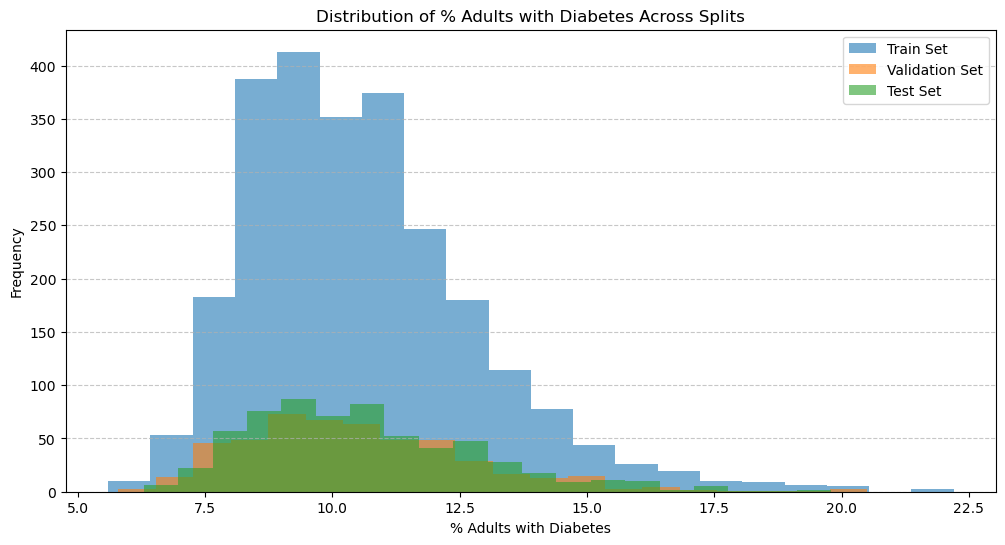

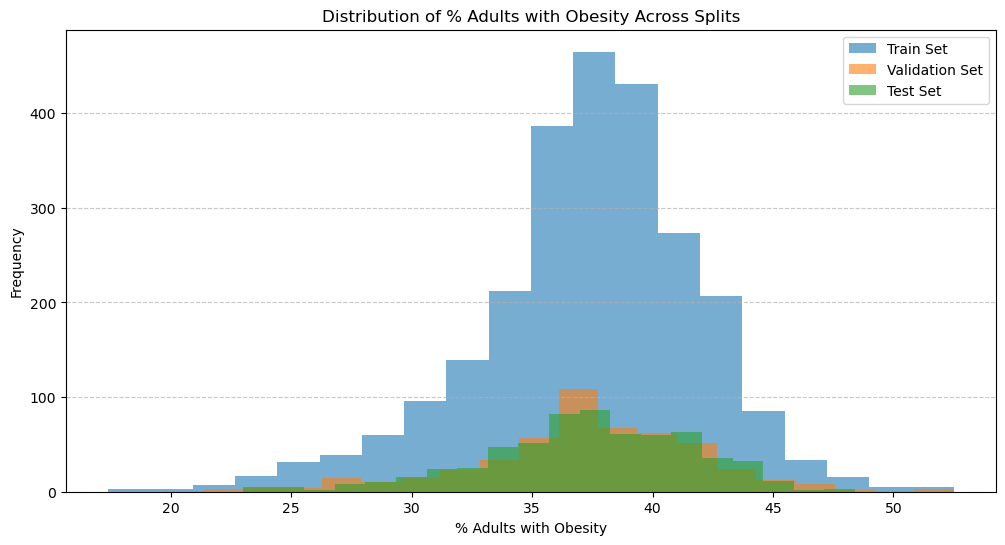

In [6]:
# Plot histograms for % Adults with Diabetes and % Adults with Obesity
columns_to_plot = ["% Adults with Diabetes", "% Adults with Obesity"]
titles = [
    "Distribution of % Adults with Diabetes Across Splits",
    "Distribution of % Adults with Obesity Across Splits"
]

for column, title in zip(columns_to_plot, titles):
    plt.figure(figsize=(12, 6))
    for split_name, split_data in {"Train": train_data, "Validation": val_data, "Test": test_data}.items():
        plt.hist(split_data[column], bins=20, alpha=0.6, label=f"{split_name} Set")
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


## Grouping features

In [7]:
features_by_category = {
    "Health Behaviors": [
        "% Adults Reporting Currently Smoking",
        "% Adults with Obesity",
        "% Physically Inactive",
        "% With Access to Exercise Opportunities",
        "% Excessive Drinking",
        "% Driving Deaths with Alcohol Involvement"
    ],
    "Health Outcomes": [
        "Deaths",
        "Years of Potential Life Lost Rate",
        "% Fair or Poor Health",
        "Average Number of Physically Unhealthy Days",
        "Average Number of Mentally Unhealthy Days",
        "% Low Birthweight",
        "Chlamydia Rate",
        "Teen Birth Rate",
        "Injury Death Rate",
        "Child Mortality Rate",
        "Infant Mortality Rate",
        "% Frequent Physical Distress",
        "% Frequent Mental Distress",
        "% Adults with Diabetes",
        "HIV Prevalence Rate",
        "Drug Overdose Mortality Rate"
    ],
    "Access to Care": [
        "% Uninsured",
        "% Uninsured Adults",
        "% Uninsured Children",
        "Primary Care Physicians Rate",
        "Dentist Rate",
        "Mental Health Provider Rate",
        "Preventable Hospitalization Rate",
        "Other Primary Care Provider Rate",
        "% with Annual Mammogram",
        "% Vaccinated"
    ],
    "Socio-economic Factors": [
        "% Completed High School",
        "% Some College",
        "% Unemployed",
        "% Children in Poverty",
        "Income Ratio",
        "% Children in Single-Parent Households",
        "Social Association Rate"
        "% Disconnected Youth",
        "High School Graduation Rate",
        "Average Grade Performance",
        "Average Grade Performance.1",
        "Segregation Index",
        "Segregation Index.1",
        "School Funding Adequacy",
        "Gender Pay Gap",
        "Median Household Income",
        "% Enrolled in Free or Reduced Lunch",
        "% Household Income Required for Child Care Expenses",
        "Child Care Centers per 1,000 Children"
    ],
    "Physical Environment": [
        "Food Environment Index",
        "% Food Insecure",
        "% Limited Access to Healthy Foods",
        "Average Daily PM2.5",
        "Presence of Water Violation",
        "% Severe Housing Problems",
        "% Drive Alone to Work",
        "% Long Commute - Drives Alone",
        "% Households with Severe Cost Burden",
        "% Households with Broadband Access",
        "Traffic Volume"
    ],
    "Demographics": [
        "Population",
        "% Less than 18 Years of Age",
        "% 65 and Over",
        "% Black",
        "% American Indian or Alaska Native",
        "% Asian",
        "% Native Hawaiian or Other Pacific Islander",
        "% Hispanic",
        "% Non-Hispanic White",
        "% Not Proficient in English",
        "% Female",
        "% Rural"
    ]
}

In [8]:
# Filter out non-numeric features
numeric_columns = train_data.select_dtypes(include=[np.number]).columns

# Initialize the lists with intersection and numeric filtering
health_behaviors_features = [
    feature for feature in features_by_category["Health Behaviors"] 
    if feature in train_data.columns and feature in numeric_columns
]

access_to_care_features = [
    feature for feature in features_by_category["Access to Care"] 
    if feature in train_data.columns and feature in numeric_columns
]

socio_economic_features = [
    feature for feature in features_by_category["Socio-economic Factors"] 
    if feature in train_data.columns and feature in numeric_columns
]

physical_environment_features = [
    feature for feature in features_by_category["Physical Environment"] 
    if feature in train_data.columns and feature in numeric_columns
]

demographics_features = [
    feature for feature in features_by_category["Demographics"] 
    if feature in train_data.columns and feature in numeric_columns
]

# Combine all features into a single list (union of all categories)
all_features = list(
    set(
        health_behaviors_features +
        access_to_care_features +
        socio_economic_features +
        physical_environment_features +
        demographics_features
    )
)

## Modelling and RMSEs

In [9]:
# Dictionary to store results
results = {}
models = {}

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': np.linspace(0.01, 0.2, 5),
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 5, 10]
}

# Create a dictionary of feature sets for models
feature_sets = {
    "Model 1 (All Features)": all_features,
    "Model 2 (Health Behaviors)": health_behaviors_features,
    "Model 3 (Access to Care)": access_to_care_features,
    "Model 4 (Socio-economic Factors)": socio_economic_features,
    "Model 5 (Physical Environment)": physical_environment_features,
    "Model 6 (Demographics)": demographics_features
}

# Initialize KFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform Randomized Search and model evaluation
for feature_set_name, feature_set in feature_sets.items():
    print(f"Tuning hyperparameters for {feature_set_name}...")
    
    fold_rmse = []
    
    # Cross-validation with hyperparameter tuning
    for train_index, val_index in kf.split(train_data):
        # Split into train and validation sets for this fold
        train_fold = train_data.iloc[train_index]
        val_fold = train_data.iloc[val_index]

        X_train_fold = train_fold[feature_set]
        y_train_fold = train_fold[target]
        X_val_fold = val_fold[feature_set]
        y_val_fold = val_fold[target]
        
        # Perform Randomized Search
        model = XGBRegressor(random_state=42)
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_distributions,
            n_iter=20,  # Limit to 20 combinations
            cv=3,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            random_state=42
        )
        random_search.fit(X_train_fold, y_train_fold)
        
        # Get the best model
        best_model = random_search.best_estimator_
        models[feature_set_name] = best_model
        
        # Predict and calculate RMSE for the validation fold
        y_pred_fold = best_model.predict(X_val_fold)
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
        fold_rmse.append(rmse.round(2))
    
    # Evaluate the best model on the entire validation set
    X_val = val_data[feature_set]
    y_val = val_data[target]
    y_pred_val = best_model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    
    # Evaluate the best model on the test set
    X_test = test_data[feature_set]
    y_test = test_data[target]
    y_pred_test = best_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    # Store results
    results[feature_set_name] = {
        "Best Parameters": random_search.best_params_,
        "Cross-Validation RMSEs": fold_rmse,
        "Validation RMSE": val_rmse,
        "Test RMSE": test_rmse
    }

# Display the results
for model_name, rmses in results.items():
    print(f"Results for {model_name}:")
    print(f"  Best Parameters: {rmses['Best Parameters']}")
    print(f"  Cross-Validation RMSEs: {rmses['Cross-Validation RMSEs']}")
    print(f"  Validation RMSE: {rmses['Validation RMSE']:.2f}")
    print(f"  Test RMSE: {rmses['Test RMSE']:.2f}\n")

Tuning hyperparameters for Model 1 (All Features)...
Tuning hyperparameters for Model 2 (Health Behaviors)...
Tuning hyperparameters for Model 3 (Access to Care)...
Tuning hyperparameters for Model 4 (Socio-economic Factors)...
Tuning hyperparameters for Model 5 (Physical Environment)...
Tuning hyperparameters for Model 6 (Demographics)...
Results for Model 1 (All Features):
  Best Parameters: {'reg_lambda': 5, 'reg_alpha': 0.1, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': np.float64(0.15250000000000002)}
  Cross-Validation RMSEs: [np.float64(0.55), np.float64(0.5), np.float64(0.54), np.float64(0.45), np.float64(0.51)]
  Validation RMSE: 0.31
  Test RMSE: 0.51

Results for Model 2 (Health Behaviors):
  Best Parameters: {'reg_lambda': 5, 'reg_alpha': 0.1, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': np.float64(0.15250000000000002)}
  Cross-Validation RMSEs: [np.float64(1.0), np.float64(1.02), np.float64(1.03), np.float64(0.93), np.float64(0.95)]
  Validation RMSE: 0.78

## Conclusion: 
### Feature groups in order of importance (low - high RMSE): 
### Socio-economic factors, Health behaviours, Demographics, Physical environment, Access to Care. 

In [10]:
print(all_features)

['% Rural', '% Uninsured', '% Physically Inactive', '% Severe Housing Problems', '% Uninsured Children', 'Food Environment Index', '% Food Insecure', '% Driving Deaths with Alcohol Involvement', '% Unemployed', 'Dentist Rate', '% Limited Access to Healthy Foods', 'Average Daily PM2.5', '% Completed High School', '% Less than 18 Years of Age', '% Native Hawaiian or Other Pacific Islander', '% Hispanic', '% Households with Broadband Access', 'Traffic Volume', '% Children in Single-Parent Households', 'School Funding Adequacy', '% 65 and Over', '% Long Commute - Drives Alone', '% With Access to Exercise Opportunities', '% Households with Severe Cost Burden', '% Children in Poverty', '% Drive Alone to Work', '% Adults Reporting Currently Smoking', 'Gender Pay Gap', 'Income Ratio', '% Non-Hispanic White', '% Female', '% Adults with Obesity', '% American Indian or Alaska Native', '% Not Proficient in English', 'Median Household Income', '% Excessive Drinking', 'Other Primary Care Provider Ra

## Feature Importance

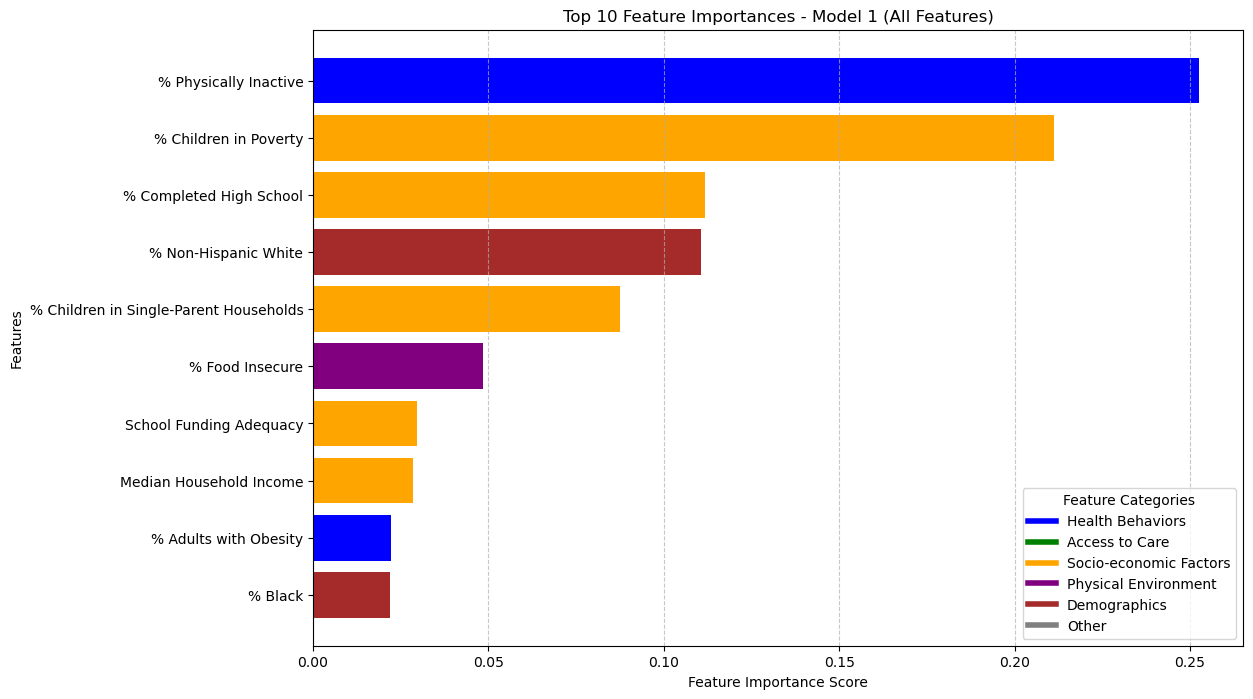

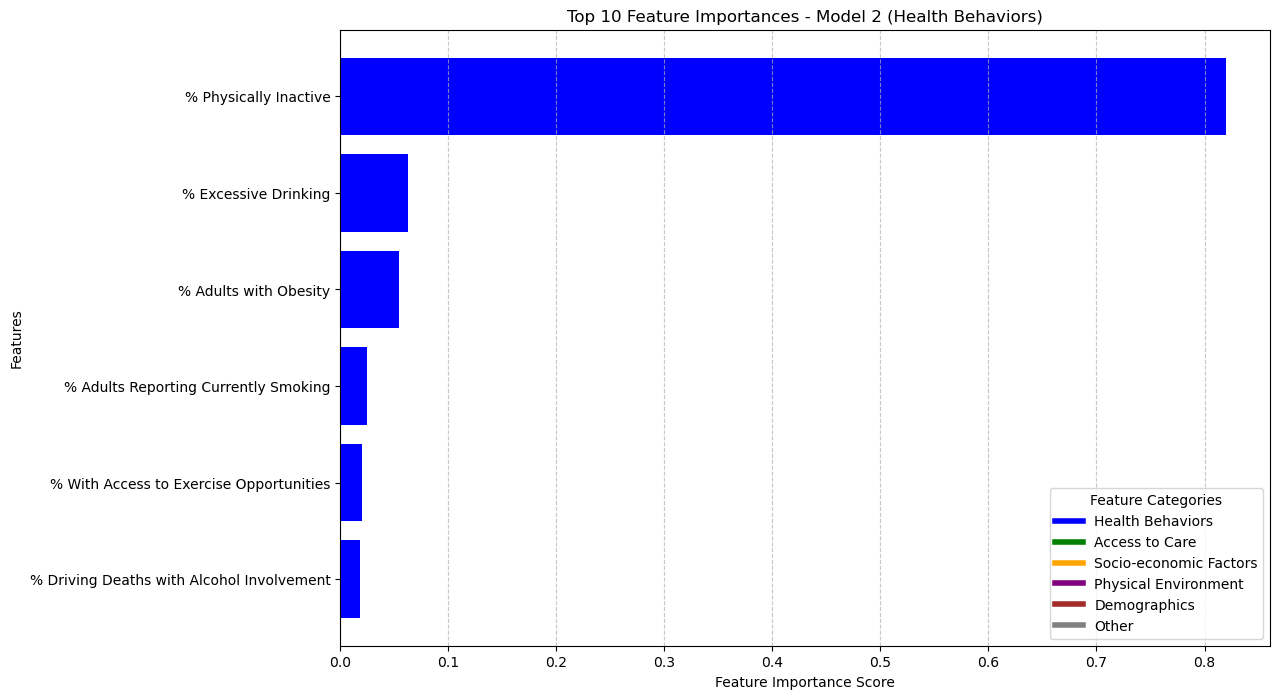

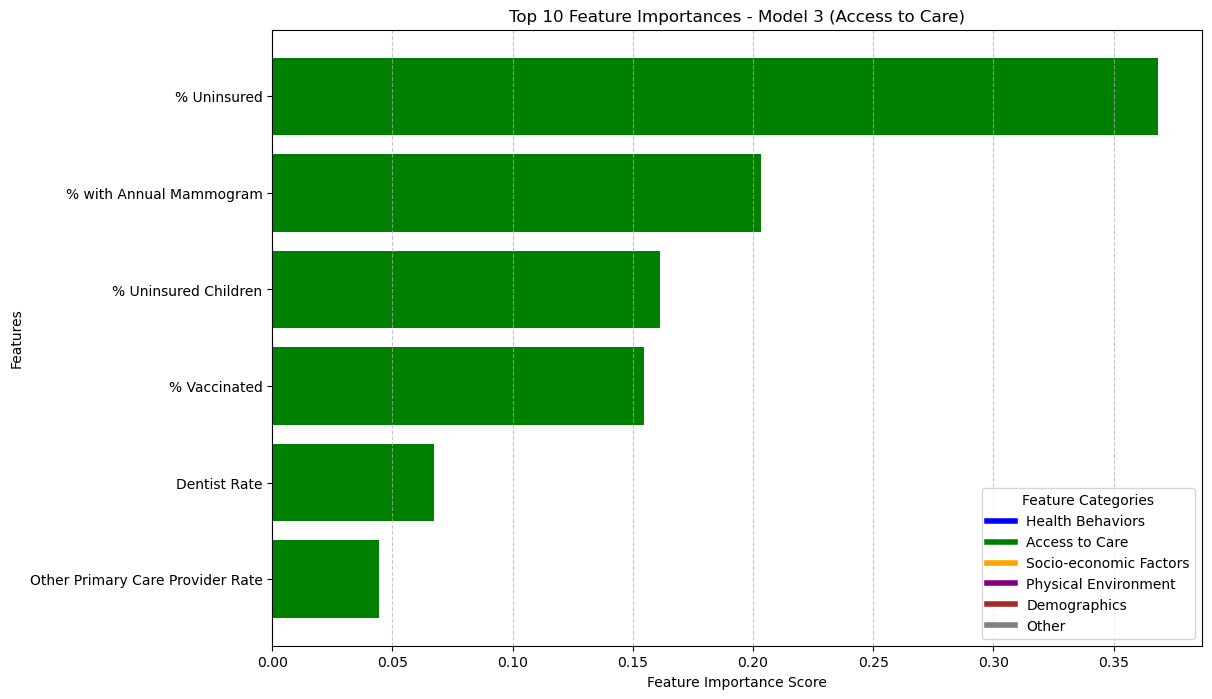

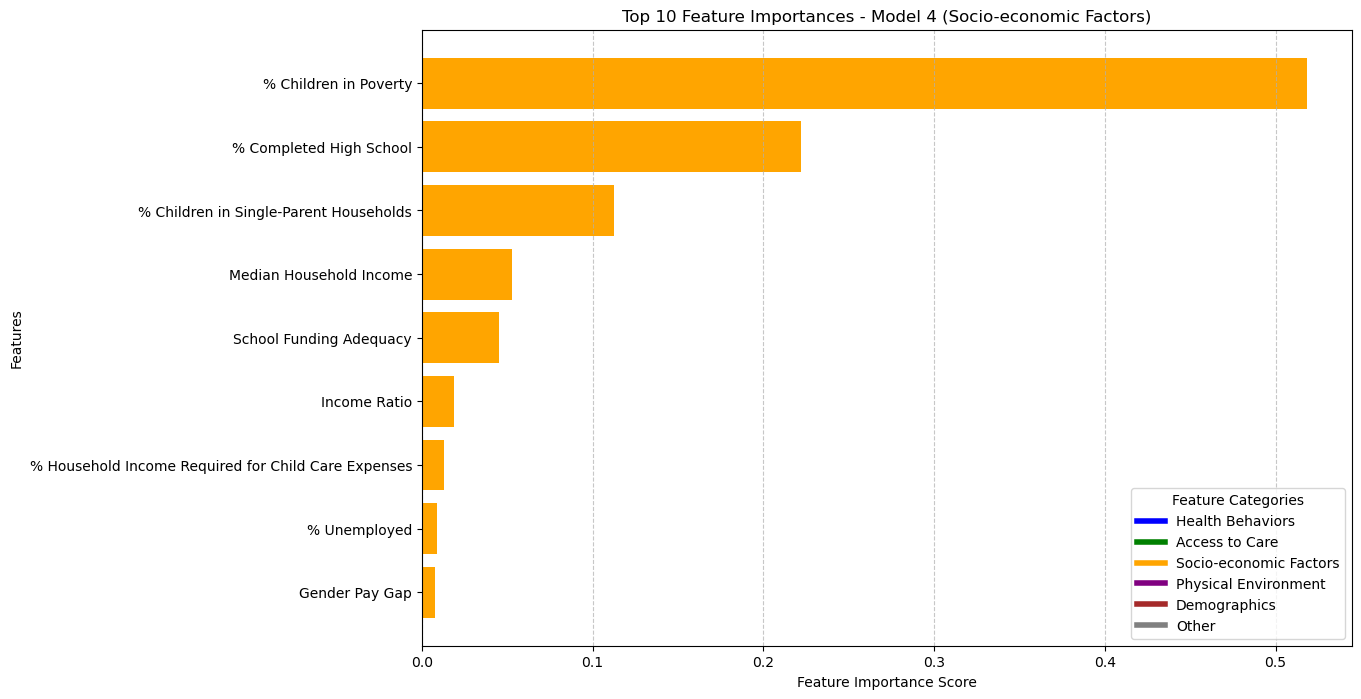

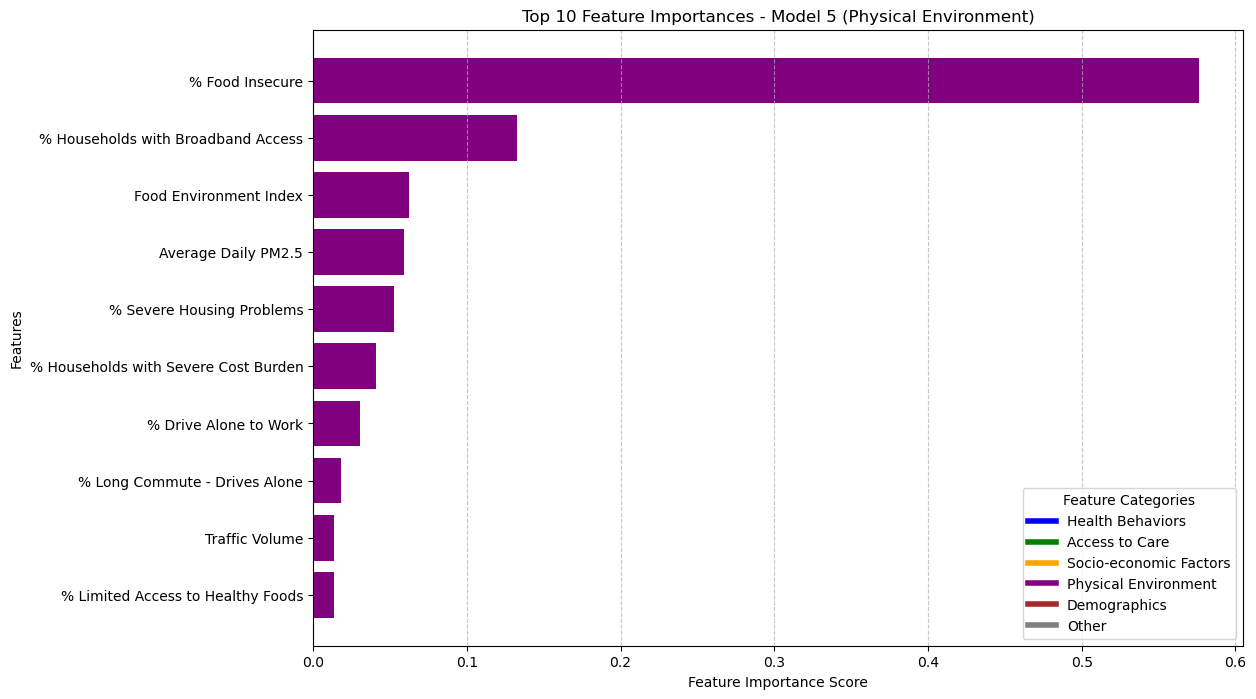

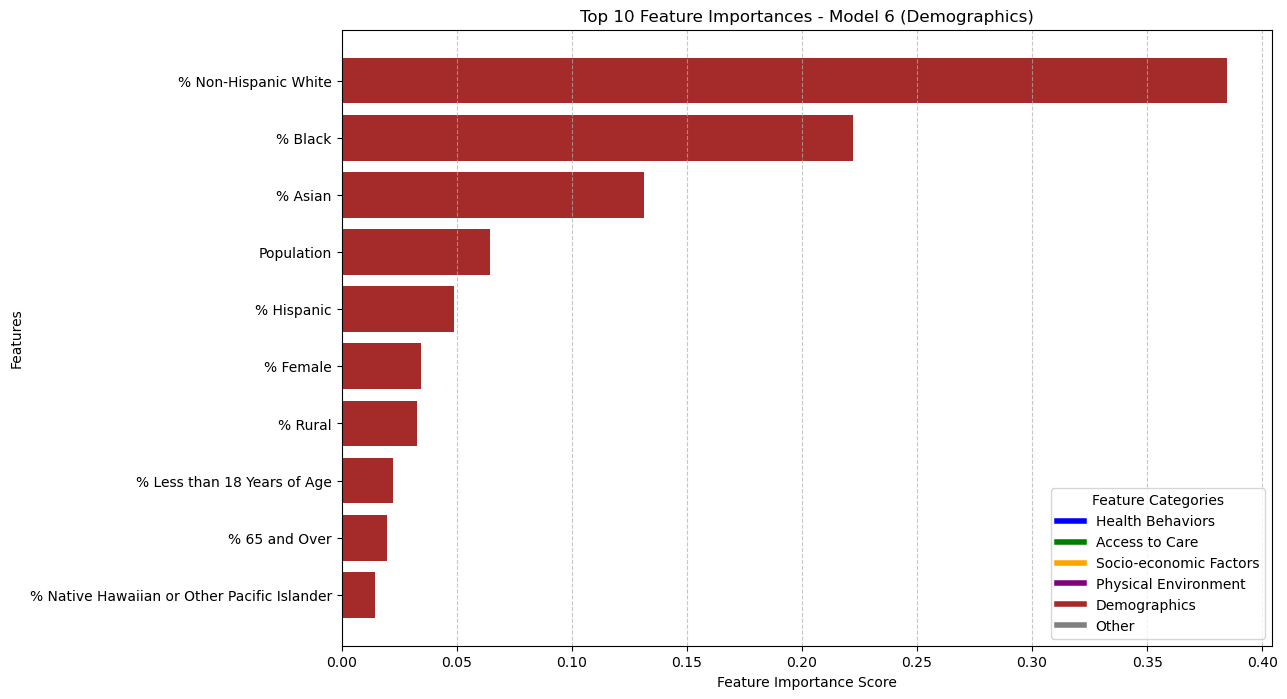

In [11]:
# Define colors for feature categories
category_colors = {
    "Health Behaviors": "blue",
    "Access to Care": "green",
    "Socio-economic Factors": "orange",
    "Physical Environment": "purple",
    "Demographics": "brown",
    "Other": "gray"  # Default color for unmapped features
}

# Mapping features to their categories
feature_categories = {
    **{feature: "Health Behaviors" for feature in health_behaviors_features},
    **{feature: "Access to Care" for feature in access_to_care_features},
    **{feature: "Socio-economic Factors" for feature in socio_economic_features},
    **{feature: "Physical Environment" for feature in physical_environment_features},
    **{feature: "Demographics" for feature in demographics_features}
}

# Plot feature importances for all models
for model_name, model in models.items():
    # Match the feature set to the model
    feature_set = {
        "Model 1 (All Features)": all_features,
        "Model 2 (Health Behaviors)": health_behaviors_features,
        "Model 3 (Access to Care)": access_to_care_features,
        "Model 4 (Socio-economic Factors)": socio_economic_features,
        "Model 5 (Physical Environment)": physical_environment_features,
        "Model 6 (Demographics)": demographics_features
    }[model_name]
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    sorted_features = [feature_set[i] for i in indices]
    sorted_importances = importances[indices]

    # Assign colors to the features
    sorted_colors = [
        category_colors.get(feature_categories.get(feature, "Other"), "gray")
        for feature in sorted_features
    ]

    # Plot top 10 feature importances
    plt.figure(figsize=(12, 8))
    plt.barh(sorted_features[:10], sorted_importances[:10], align='center', color=sorted_colors[:10])
    plt.title(f"Top 10 Feature Importances - {model_name}")
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Features")
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.legend(handles=[plt.Line2D([0], [0], color=color, lw=4, label=label) 
                        for label, color in category_colors.items()],
               title="Feature Categories")
    plt.show()


## Residual Plots and Sample Predictions

Residual Analysis and Sample Predictions for Model 1 (All Features):


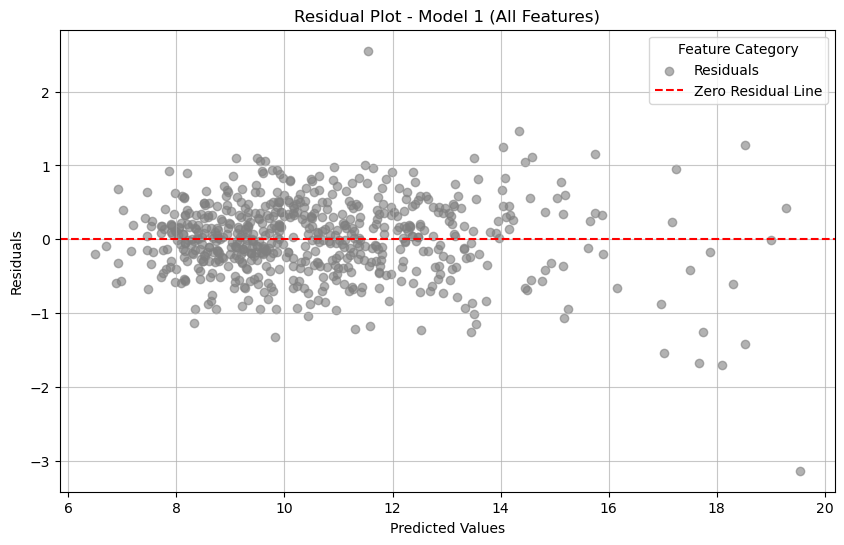

Sample Predictions:
        County           State  % Adults with Diabetes  Predicted  Residual
483  Highlands         Florida                    11.5       11.8      -0.3
462    Collier         Florida                     9.4        9.5      -0.1
377     Wright        Missouri                    12.0       12.4      -0.4
403   Anderson  South Carolina                    10.9       10.4       0.5
412   La Salle           Texas                    15.5       17.0      -1.5


Residual Analysis and Sample Predictions for Model 2 (Health Behaviors):


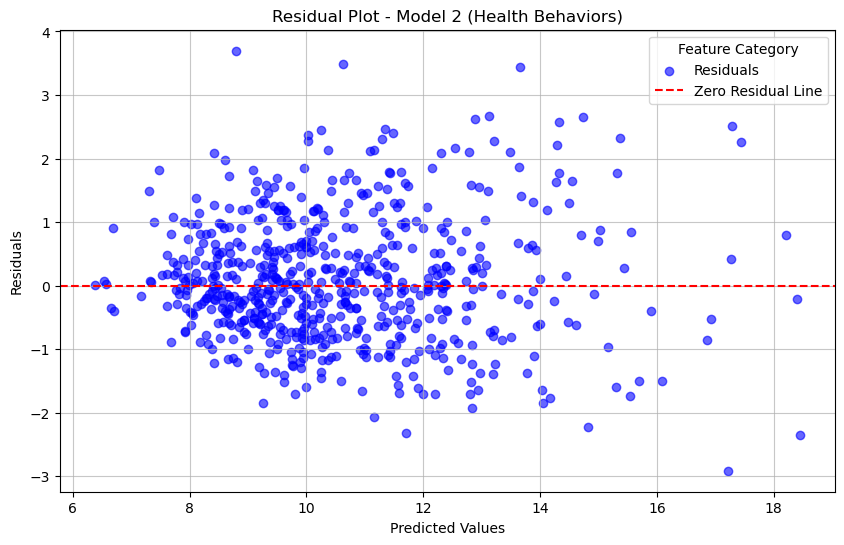

Sample Predictions:
           County          State  % Adults with Diabetes  Predicted  Residual
88   Hillsborough  New Hampshire                     7.4   9.200000      -1.8
398         Wayne       Kentucky                    12.4  14.200000      -1.8
124       Calhoun    Mississippi                    13.4  13.600000      -0.2
58       Presidio          Texas                    19.8  17.299999       2.5
11        Hidalgo     New Mexico                    12.7  12.500000       0.2


Residual Analysis and Sample Predictions for Model 3 (Access to Care):


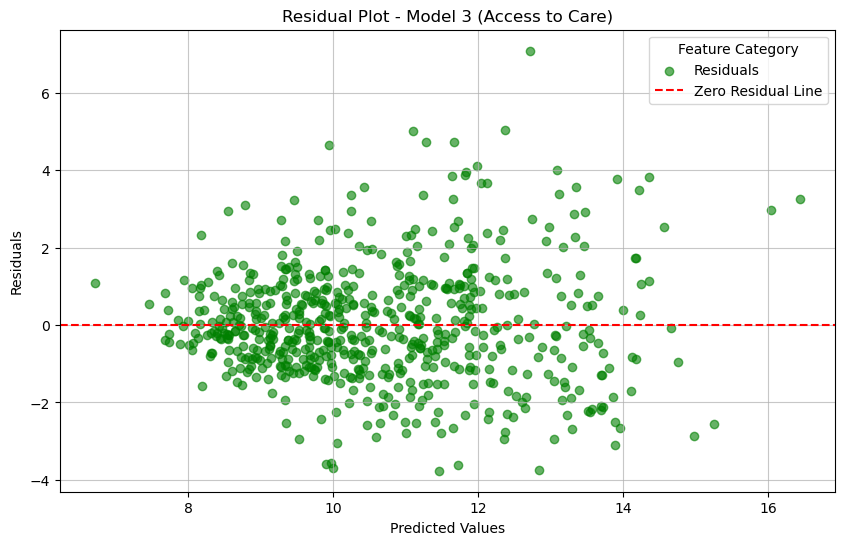

Sample Predictions:
        County          State  % Adults with Diabetes  Predicted  Residual
482     Wetzel  West Virginia                    11.3       10.5       0.8
562     Kinney          Texas                    14.4       11.7       2.7
82   Robertson          Texas                    12.2       11.2       1.0
454  Winnebago      Wisconsin                     7.6        8.3      -0.7
164   Washburn      Wisconsin                     8.1        9.1      -1.0


Residual Analysis and Sample Predictions for Model 4 (Socio-economic Factors):


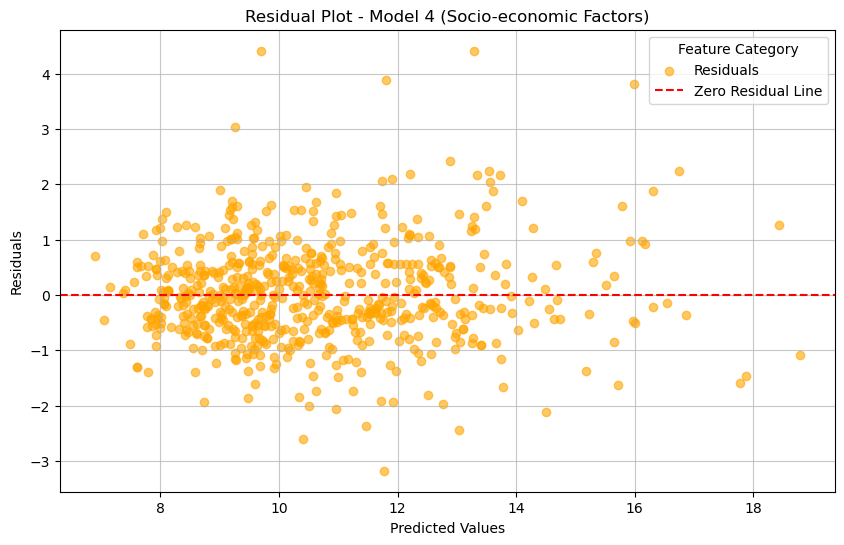

Sample Predictions:
       County          State  % Adults with Diabetes  Predicted  Residual
492    Butler       Missouri                    11.3       12.4      -1.1
360  Renville   North Dakota                     8.0        8.4      -0.4
103   Barbour  West Virginia                    12.8       11.0       1.8
369   De Soto      Louisiana                    13.4       12.7       0.7
237     Wayne           Iowa                     9.1       10.6      -1.5


Residual Analysis and Sample Predictions for Model 5 (Physical Environment):


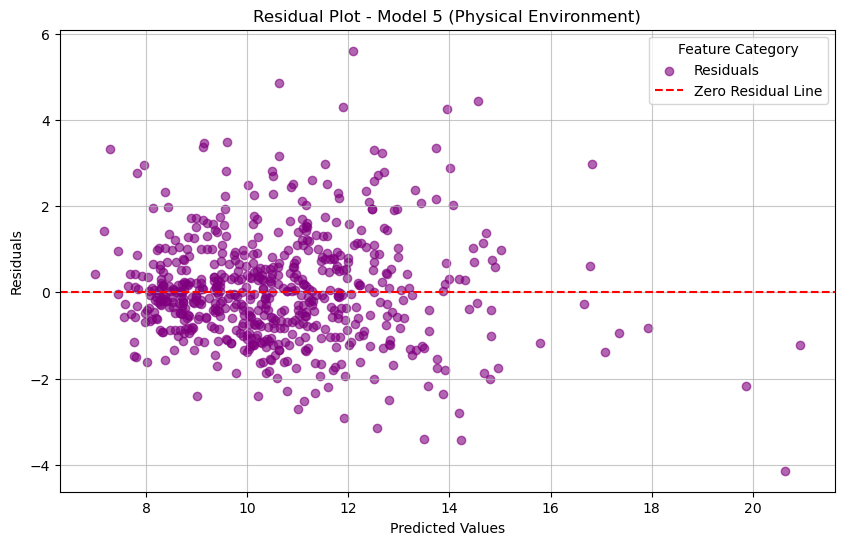

Sample Predictions:
            County      State  % Adults with Diabetes  Predicted  Residual
293           Knox   Kentucky                    13.9       13.9       0.0
201          Clark   Kentucky                    10.0       10.3      -0.3
260        Laramie    Wyoming                     8.3        8.8      -0.5
111        Shawano  Wisconsin                     8.5        8.5       0.0
273  Richmond City   Virginia                    12.5       10.8       1.7


Residual Analysis and Sample Predictions for Model 6 (Demographics):


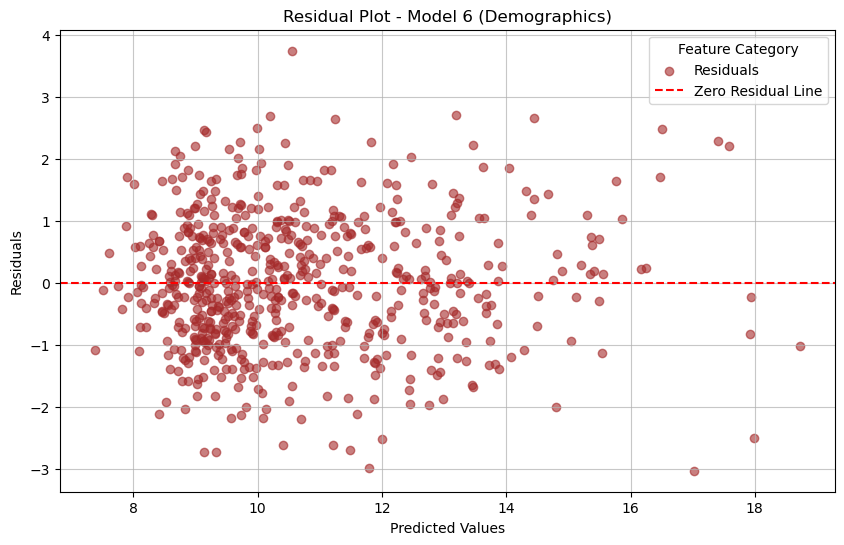

Sample Predictions:
        County           State  % Adults with Diabetes  Predicted  Residual
275  Currituck  North Carolina                     8.5        9.9      -1.4
131     Lander          Nevada                    10.6       10.2       0.4
402      Clark        Illinois                     8.5        9.5      -1.0
472    Lincoln        Arkansas                    12.2       13.1      -0.9
161    Terrell         Georgia                    16.9       15.9       1.0




In [12]:
# Plot residuals for each model and show sample predictions
for model_name, model in models.items():
    print(f"Residual Analysis and Sample Predictions for {model_name}:")

    # Match the feature set to the model
    feature_set = {
        "Model 1 (All Features)": all_features,
        "Model 2 (Health Behaviors)": health_behaviors_features,
        "Model 3 (Access to Care)": access_to_care_features,
        "Model 4 (Socio-economic Factors)": socio_economic_features,
        "Model 5 (Physical Environment)": physical_environment_features,
        "Model 6 (Demographics)": demographics_features
    }[model_name]
    
    X_test = test_data[feature_set]
    y_test = test_data[target]

    # Predictions
    y_pred_test = model.predict(X_test)

    # Calculate residuals
    residuals = y_test - y_pred_test

    # Determine the feature category for this model
    feature_category = None
    for category, features in {
        "Health Behaviors": health_behaviors_features,
        "Access to Care": access_to_care_features,
        "Socio-economic Factors": socio_economic_features,
        "Physical Environment": physical_environment_features,
        "Demographics": demographics_features,
        "Other": all_features
    }.items():
        if set(feature_set).issubset(set(features)):
            feature_category = category
            break

    # Use the color matching the feature category
    category_color = category_colors.get(feature_category, "gray")

    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_test, residuals, alpha=0.6, label="Residuals", color=category_color)
    plt.axhline(0, color='red', linestyle='--', label="Zero Residual Line")
    plt.title(f"Residual Plot - {model_name}")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.legend(title="Feature Category")
    plt.grid(alpha=0.7)
    plt.show()

    # Display sample predictions for 5 random rows
    random_indices = random.sample(range(len(test_data)), 5)
    sample_data = test_data.iloc[random_indices]
    sample_predictions = model.predict(sample_data[feature_set])

    # Include County, State, and round numbers
    sample_results = sample_data[["County", "State", target]].copy()  # Include 'County' and 'State' columns
    sample_results["Predicted"] = sample_predictions
    sample_results["Residual"] = sample_results[target] - sample_results["Predicted"]
    sample_results = sample_results.round(1)  # Round all numbers to 1 decimal place
    
    print("Sample Predictions:")
    print(sample_results)
    print("\n" + "="*80 + "\n")
